# Expert Level - Traffic Sign Recognition

This notebook systematically explores different approaches for traffic sign recognition:
- **T1**: Dataset loading
- **T2**: Different preprocessing techniques
- **T3**: Different feature extraction methods
- **T4**: Different classification models (classifiers)


We'll explore in this order:
1. **Different Preprocessing Methods**: Compare how different preprocessing affects results
2. **Different Classifiers**: Compare how different classifiers perform
3. **Different Combinations**: Find the best preprocessing + feature + classifier combination

## Simple Baseline

We'll have the following as baseline:
- **Preprocessing**: Resize + Grayscale + Gaussian Blur (standard, minimal steps)
- **Features**: HOG only (well-established feature extraction method)
- **Classifier**: SVM (commonly used baseline classifier)



In [43]:
# Imports
import cv2
import numpy as np
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2hsv
from skimage.measure import regionprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries imported successfully!")



Libraries imported successfully!


## T1: Dataset Loading

Load images and extract class IDs from filenames.


In [44]:
def load_dataset():
    """Load dataset from disk."""
    # Get project root (go up from expert/ folder)
    current_dir = os.getcwd()
    if 'expert' in current_dir:
        project_root = os.path.dirname(current_dir)
    else:
        project_root = current_dir
    
    dataset_path = os.path.join(project_root, "datasets", "dataset1") + os.sep
    
    X = []
    y = []
    image_files = glob.glob(dataset_path + '*.png', recursive=True)
    
    for i in image_files:
        filename = os.path.basename(i)
        class_id = filename[:3]
        y.append(class_id)
        
        img = cv2.imread(i)
        if img is not None:
            X.append(img)
    
    return X, y

# Load dataset
X, y = load_dataset()
print(f"✓ Loaded {len(X)} images")
print(f"✓ {len(set(y))} unique classes")
print(f"✓ Sample class IDs: {sorted(set(y))[:10]}...")



✓ Loaded 5998 images
✓ 58 unique classes
✓ Sample class IDs: ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']...


## T2: Preprocessing Methods

Different preprocessing techniques to improve image quality:

1. **Simple Grayscale**: Basic resize + grayscale conversion
2. **Grayscale + Blur**: Resize and adds Gaussian blur to reduce noise
3. **Histogram Equalization**: Improves contrast by equalizing histograms
4. **Conbination**: Resize + Blur + Histogram Equalization + Normalization


In [45]:
def preprocessing_simple(X):
    """Simple: Resize + Grayscale"""
    X_processed = []
    for x in X:
        temp_x = cv2.resize(x, (48, 48))
        temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
        X_processed.append(temp_x)
    return X_processed

def preprocessing_blur(X):
    """Blur: Resize + Grayscale + Gaussian Blur"""
    X_processed = []
    for x in X:
        temp_x = cv2.resize(x, (48, 48))
        temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
        temp_x = cv2.GaussianBlur(temp_x, (3, 3), 0)
        X_processed.append(temp_x)
    return X_processed

def preprocessing_histogram_eq(X):
    """Histogram Equalization: Equalize each channel + Resize + Grayscale"""
    X_processed = []
    for x in X:
        b, g, r = cv2.split(x)
        bH = cv2.equalizeHist(b)
        gH = cv2.equalizeHist(g)
        rH = cv2.equalizeHist(r)
        result = cv2.merge((bH, gH, rH))
        result = cv2.resize(result, (48, 48))
        result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        X_processed.append(result)
    return X_processed

def preprocessing_advanced(X):
    """Advanced: Resize + Grayscale + Blur + Histogram Equalization + Normalization"""
    X_processed = []
    for x in X:
        temp_x = cv2.resize(x, (48, 48))
        temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
        temp_x = cv2.GaussianBlur(temp_x, (3, 3), 0)
        temp_x = cv2.equalizeHist(temp_x)
        temp_x = temp_x.astype(np.float32) / 255.0
        X_processed.append(temp_x)
    return X_processed

print("✓ Preprocessing functions defined")



✓ Preprocessing functions defined


## Feature Extraction Visualization

Let's visualize what different feature extraction methods capture from images.


Visualizing all feature extraction methods on sample images...



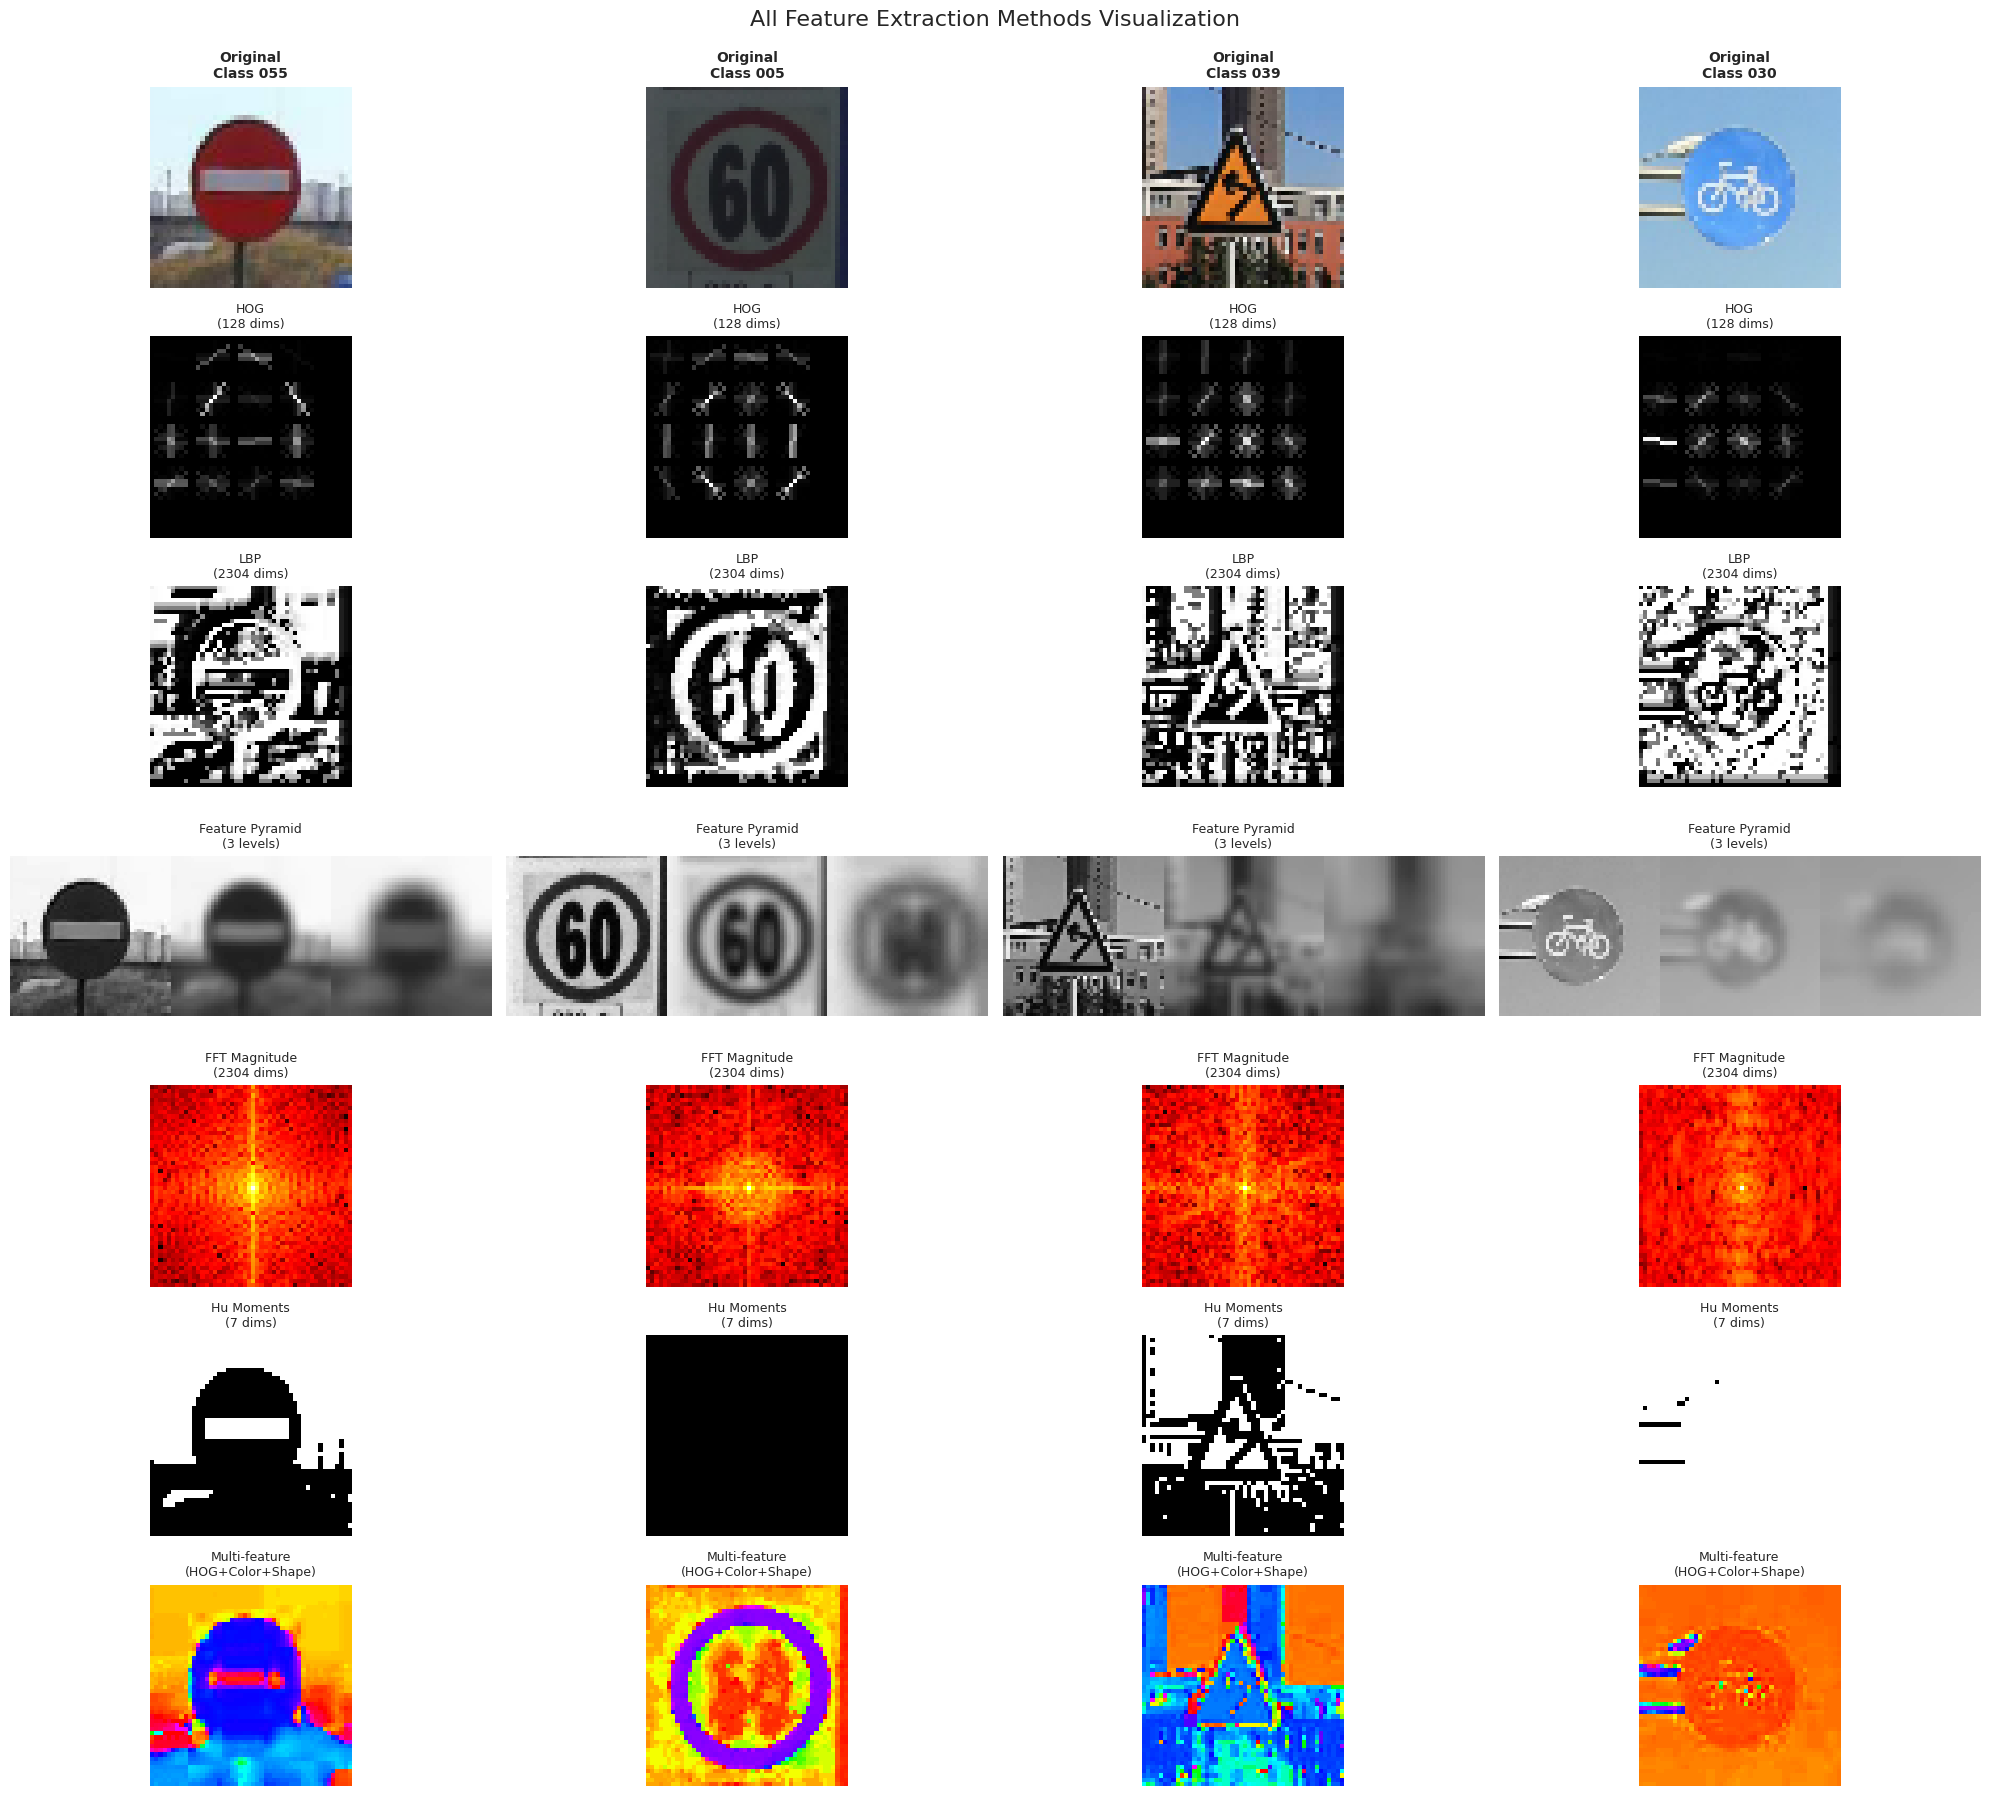

✓ HOG: Captures gradient orientations (edges/shapes)
✓ LBP: Captures texture patterns
✓ Feature Pyramid: Multi-scale representation
✓ FFT: Frequency domain patterns
✓ Hu Moments: Shape-invariant moments (from binary image)
✓ Multi-feature: Combines HOG + Color (HSV) + Shape features


In [46]:
# Visualize ALL Feature Extraction Methods
print("Visualizing all feature extraction methods on sample images...\n")

# Get a few sample images from different classes
sample_indices = [0, 500, 1000, 2000]  # Different classes
n_samples = len([i for i in sample_indices if i < len(X)])
n_features = 6  # HOG, LBP, Pyramid, FFT, Hu Moments, Multi-feature

fig, axes = plt.subplots(n_features + 1, n_samples, figsize=(20, 18))
fig.suptitle('All Feature Extraction Methods Visualization', fontsize=16, y=0.995)

for idx, sample_idx in enumerate(sample_indices):
    if sample_idx >= len(X):
        continue
    
    # Original image
    img = X[sample_idx]
    img_resized = cv2.resize(img, (48, 48))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # Row 0: Original images
    axes[0, idx].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0, idx].set_title(f'Original\nClass {y[sample_idx]}', fontsize=10, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Row 1: HOG visualization
    hog_feat, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(10, 10),
                              cells_per_block=(1, 1), visualize=True)
    axes[1, idx].imshow(hog_image, cmap='gray')
    axes[1, idx].set_title(f'HOG\n({len(hog_feat)} dims)', fontsize=9)
    axes[1, idx].axis('off')
    
    # Row 2: LBP visualization
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(img_gray, n_points, radius)
    axes[2, idx].imshow(lbp, cmap='gray')
    axes[2, idx].set_title(f'LBP\n({lbp.size} dims)', fontsize=9)
    axes[2, idx].axis('off')
    
    # Row 3: Feature Pyramid visualization
    num_layers = 3
    gaussian_pyr = [img_gray]
    image = img_gray
    for i in range(1, num_layers):
        image = cv2.pyrDown(image)
        gaussian_pyr.append(image)
    
    # Show all pyramid levels side by side
    pyramid_display = np.hstack([cv2.resize(level, (48, 48)) for level in gaussian_pyr])
    axes[3, idx].imshow(pyramid_display, cmap='gray')
    axes[3, idx].set_title(f'Feature Pyramid\n({num_layers} levels)', fontsize=9)
    axes[3, idx].axis('off')
    
    # Row 4: FFT visualization
    f = np.fft.fft2(img_gray)
    f_shift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
    axes[4, idx].imshow(magnitude_spectrum, cmap='hot')
    axes[4, idx].set_title(f'FFT Magnitude\n({magnitude_spectrum.size} dims)', fontsize=9)
    axes[4, idx].axis('off')
    
    # Row 5: Hu Moments visualization (show binary image used)
    ret, binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    axes[5, idx].imshow(binary, cmap='gray')
    axes[5, idx].set_title(f'Hu Moments\n(7 dims)', fontsize=9)
    axes[5, idx].axis('off')
    
    # Row 6: Multi-feature visualization (show combined representation)
    # Create a visual representation showing different feature types
    hsv_image = rgb2hsv(img_resized)
    hue_channel = hsv_image[:, :, 0]
    axes[6, idx].imshow(hue_channel, cmap='hsv')
    axes[6, idx].set_title(f'Multi-feature\n(HOG+Color+Shape)', fontsize=9)
    axes[6, idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ HOG: Captures gradient orientations (edges/shapes)")
print("✓ LBP: Captures texture patterns")
print("✓ Feature Pyramid: Multi-scale representation")
print("✓ FFT: Frequency domain patterns")
print("✓ Hu Moments: Shape-invariant moments (from binary image)")
print("✓ Multi-feature: Combines HOG + Color (HSV) + Shape features")


Comparing feature distributions across all extraction methods...



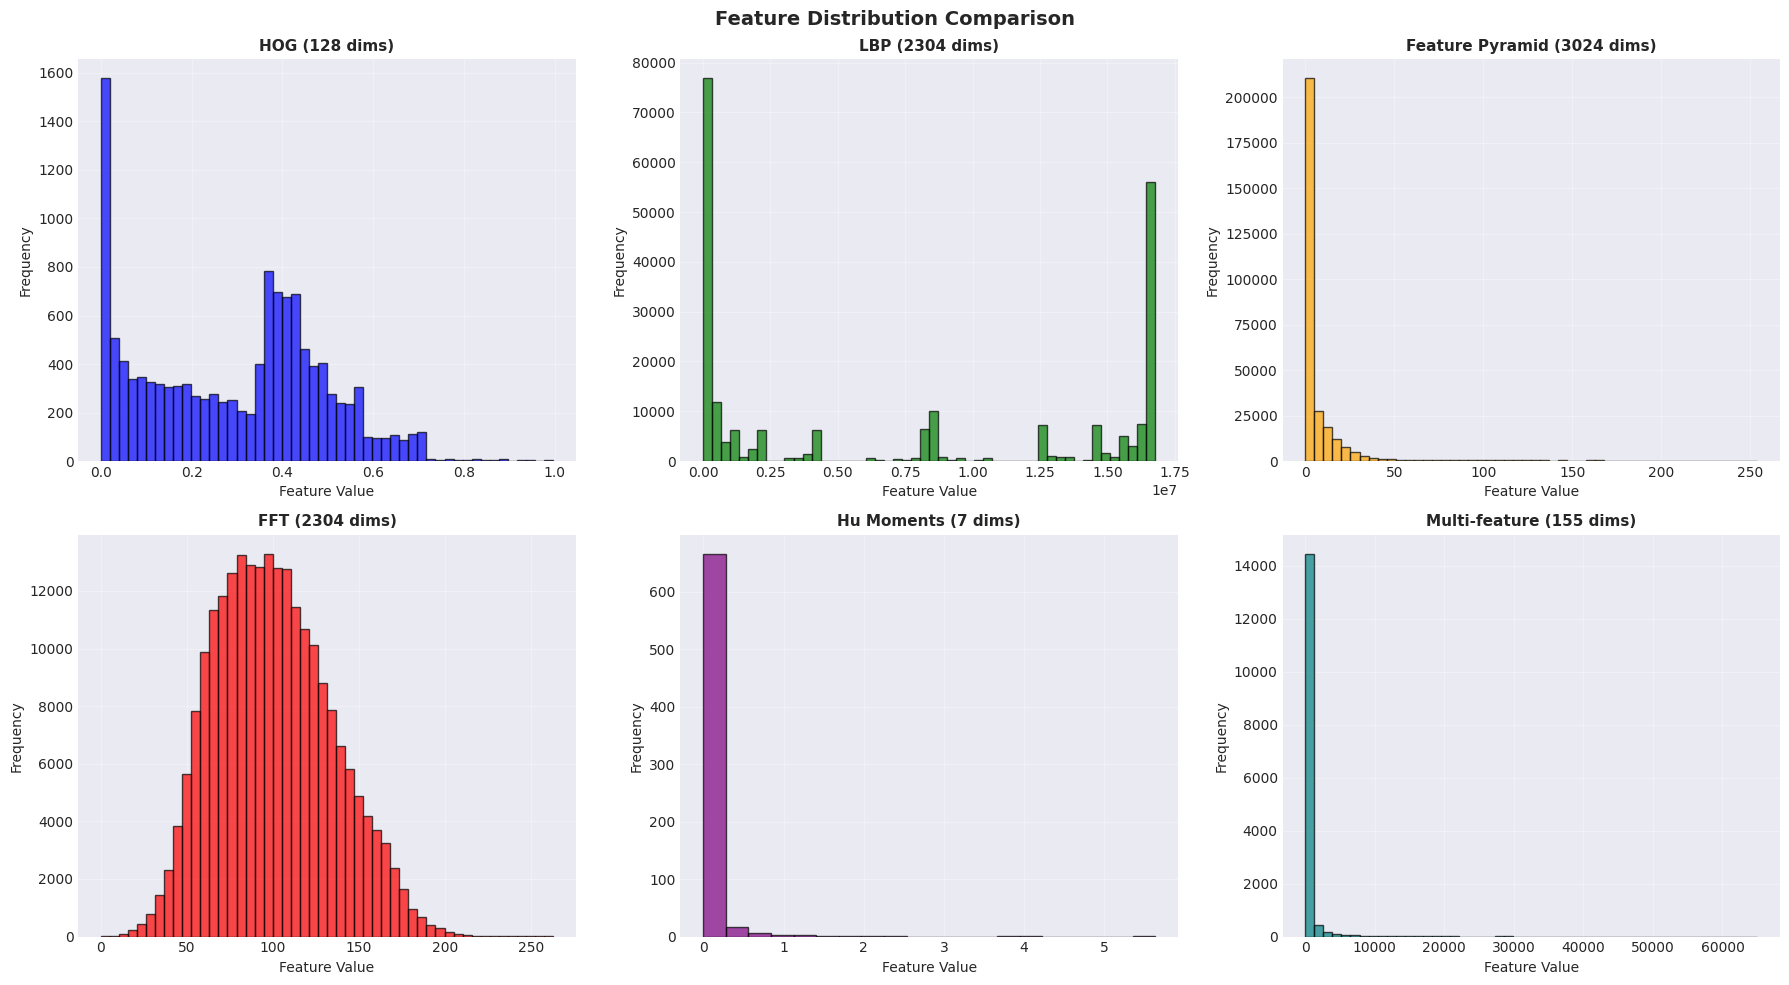

✓ HOG: 128 dims, range [0.00, 1.00]
✓ LBP: 2304 dims, range [0.00, 16777215.00]
✓ Pyramid: 3024 dims, range [0.00, 254.00]
✓ FFT: 2304 dims, range [0.00, 262.80]
✓ Hu Moments: 7 dims, range [-0.00, 5.63]
✓ Multi-feature: 155 dims, range [0.00, 65022.00]


In [47]:
# Compare Feature Distributions for ALL Methods
print("Comparing feature distributions across all extraction methods...\n")

# Preprocess sample
X_sample = preprocessing_blur(X[:100])  # Use 100 samples for speed

# Extract all features
hog_features = feature_HOG(X_sample)
lbp_features = feature_LBP(X_sample)
pyramid_features = feature_pyramid(X_sample)
fft_features = feature_FFT(X_sample)
hu_features = feature_HuMoments(X_sample)
multi_features = feature_multi(X[:100], preprocessing_advanced(X[:100]))

# Plot feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distribution Comparison', fontsize=14, fontweight='bold')

# HOG
axes[0, 0].hist(hog_features.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title(f'HOG ({hog_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Feature Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# LBP
axes[0, 1].hist(lbp_features.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title(f'LBP ({lbp_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Feature Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Feature Pyramid
axes[0, 2].hist(pyramid_features.flatten(), bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 2].set_title(f'Feature Pyramid ({pyramid_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[0, 2].set_xlabel('Feature Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# FFT
axes[1, 0].hist(fft_features.flatten(), bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title(f'FFT ({fft_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Feature Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Hu Moments
axes[1, 1].hist(hu_features.flatten(), bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title(f'Hu Moments ({hu_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Feature Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# Multi-feature
axes[1, 2].hist(multi_features.flatten(), bins=50, alpha=0.7, color='teal', edgecolor='black')
axes[1, 2].set_title(f'Multi-feature ({multi_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('Feature Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ HOG: {hog_features.shape[1]} dims, range [{hog_features.min():.2f}, {hog_features.max():.2f}]")
print(f"✓ LBP: {lbp_features.shape[1]} dims, range [{lbp_features.min():.2f}, {lbp_features.max():.2f}]")
print(f"✓ Pyramid: {pyramid_features.shape[1]} dims, range [{pyramid_features.min():.2f}, {pyramid_features.max():.2f}]")
print(f"✓ FFT: {fft_features.shape[1]} dims, range [{fft_features.min():.2f}, {fft_features.max():.2f}]")
print(f"✓ Hu Moments: {hu_features.shape[1]} dims, range [{hu_features.min():.2f}, {hu_features.max():.2f}]")
print(f"✓ Multi-feature: {multi_features.shape[1]} dims, range [{multi_features.min():.2f}, {multi_features.max():.2f}]")


## Classifier Mechanisms Explained

### 1. SVM (Support Vector Machine)

**How SVM Works:**

SVM finds the optimal hyperplane (decision boundary) that separates classes with maximum margin. Support vectors are the data points closest to the hyperplane.

![SVM Mechanism](https://upload.wikimedia.org/wikipedia/commons/2/2a/Svm_max_sep_hyperplane_with_margin.png)

*Image source: Wikipedia - Shows SVM finding optimal hyperplane with maximum margin*

**Key Concepts:**
- **Hyperplane**: Decision boundary separating classes
- **Support Vectors**: Critical training samples on the margin
- **Margin**: Distance between hyperplane and nearest data points
- **Kernel Trick**: Maps data to higher dimensions for non-linear separation
- **Advantages**: Good for high-dimensional data, memory efficient (only uses support vectors)
- **Disadvantages**: Slow for large datasets, sensitive to feature scaling


Visualizing SVM decision boundary on 2D feature projection...



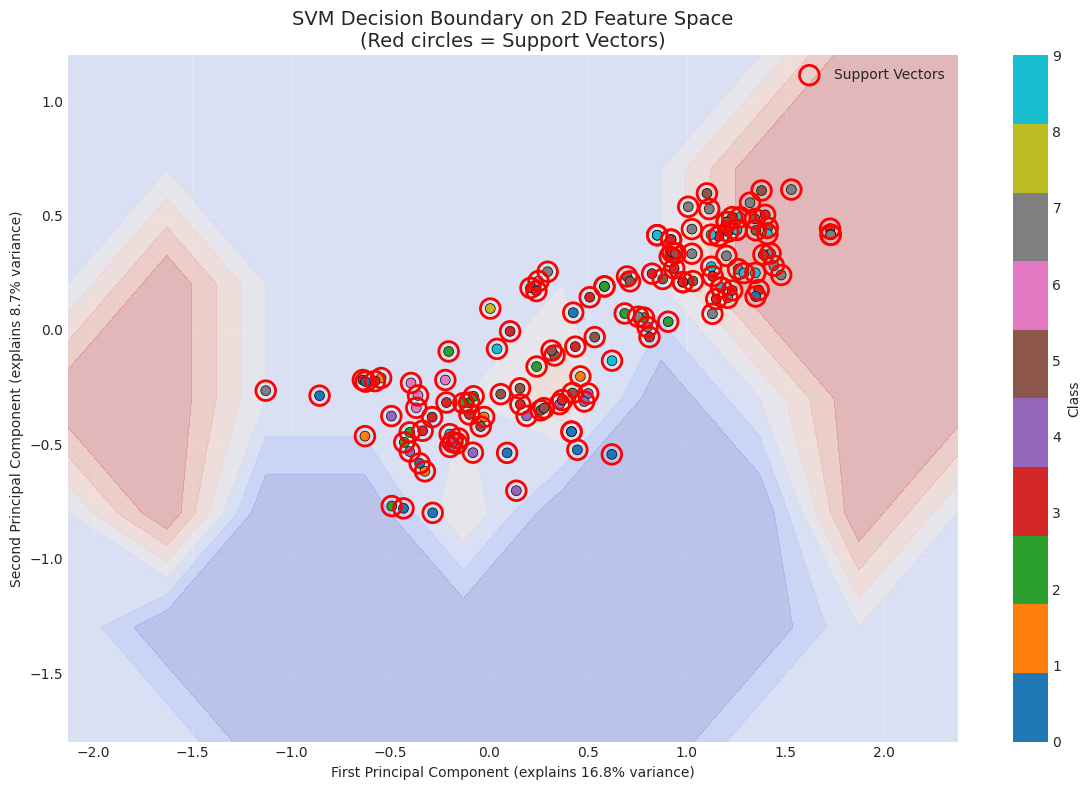

✓ Total samples: 136
✓ Support vectors: 136 (100.0% of data)
✓ Support vectors are the critical samples that define the decision boundary


In [48]:
# Visualize SVM Decision Boundary (2D projection)
print("Visualizing SVM decision boundary on 2D feature projection...\n")

# Use PCA to reduce to 2D for visualization
X_processed_viz = preprocessing_blur(X[:500])  # Use subset for speed
X_features_viz = feature_HOG(X_processed_viz)
y_viz = y[:500]

# Reduce to 2D using PCA
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_features_viz)

# Get unique classes and assign colors
unique_classes = sorted(set(y_viz))[:10]  # Use first 10 classes
class_to_num = {cls: idx for idx, cls in enumerate(unique_classes)}
y_numeric = [class_to_num.get(cls, -1) for cls in y_viz]

# Filter to only classes we're visualizing
mask = np.array([cls in unique_classes for cls in y_viz])
X_2d_filtered = X_2d[mask]
y_numeric_filtered = np.array(y_numeric)[mask]

# Train SVM
svm_viz = SVC(kernel='rbf', C=1.0)
svm_viz.fit(X_2d_filtered, y_numeric_filtered)

# Create mesh for decision boundary
h = 0.5
x_min, x_max = X_2d_filtered[:, 0].min() - 1, X_2d_filtered[:, 0].max() + 1
y_min, y_max = X_2d_filtered[:, 1].min() - 1, X_2d_filtered[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_2d_filtered[:, 0], X_2d_filtered[:, 1], 
                     c=y_numeric_filtered, cmap=plt.cm.tab10, 
                     edgecolors='black', linewidths=0.5, s=50)

# Highlight support vectors
plt.scatter(X_2d_filtered[svm_viz.support_][:, 0], 
           X_2d_filtered[svm_viz.support_][:, 1],
           s=200, facecolors='none', edgecolors='red', 
           linewidths=2, label='Support Vectors')

plt.xlabel(f'First Principal Component (explains {pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Second Principal Component (explains {pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('SVM Decision Boundary on 2D Feature Space\n(Red circles = Support Vectors)', fontsize=14)
plt.legend()
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Total samples: {len(X_2d_filtered)}")
print(f"✓ Support vectors: {len(svm_viz.support_)} ({len(svm_viz.support_)/len(X_2d_filtered)*100:.1f}% of data)")
print("✓ Support vectors are the critical samples that define the decision boundary")


In [49]:
def feature_HOG(X_processed):
    """HOG: Histogram of Oriented Gradients"""
    X_features = []
    for x in X_processed:
        x_feature = hog(x, orientations=8, pixels_per_cell=(10, 10),
                        cells_per_block=(1, 1), visualize=False)
        X_features.append(x_feature)
    return np.array(X_features)

def feature_LBP(X_processed):
    """LBP: Local Binary Pattern"""
    X_features = []
    radius = 3
    n_points = 8 * radius
    for x in X_processed:
        x_feature = local_binary_pattern(x, n_points, radius)
        x_feature = x_feature.reshape(-1)
        X_features.append(x_feature)
    return np.array(X_features)

def feature_pyramid(X_processed):
    """Feature Pyramid: Multi-scale Laplacian pyramid"""
    num_layers = 3
    X_features = []
    for x in X_processed:
        gaussian_pyr = [x]
        image = x
        for i in range(1, num_layers):
            image = cv2.pyrDown(image)
            gaussian_pyr.append(image)
        
        laplacian_pyr = [gaussian_pyr[num_layers - 1]]
        for i in range(num_layers - 1, 0, -1):
            expanded = cv2.pyrUp(gaussian_pyr[i])
            laplacian = cv2.subtract(gaussian_pyr[i - 1], expanded)
            laplacian_pyr.append(laplacian)
        
        flattened_arrays = [arr.flatten() for arr in laplacian_pyr]
        x_feature = np.concatenate(flattened_arrays)
        X_features.append(x_feature)
    return np.array(X_features)

def feature_FFT(X_processed):
    """FFT: Frequency domain magnitude spectrum"""
    X_features = []
    for x in X_processed:
        f = np.fft.fft2(x)
        f_shift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
        magnitude_spectrum = magnitude_spectrum.reshape(-1)
        X_features.append(magnitude_spectrum)
    return np.array(X_features)

def feature_HuMoments(X_processed):
    """Hu Moments: 7 invariant shape moments"""
    X_features = []
    for x in X_processed:
        ret, binary = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            hu_moments = np.zeros(7)
        else:
            moments = cv2.moments(contours[0])
            hu_moments = cv2.HuMoments(moments).reshape(-1)
        X_features.append(hu_moments)
    return np.array(X_features)

def feature_multi(X, X_processed):
    """Multi-feature: HOG + Color (HSV) + Shape features"""
    X_features = []
    for x, x_processed in zip(X, X_processed):
        # HOG
        hog_feature = hog(x_processed, orientations=8, pixels_per_cell=(10, 10),
                          cells_per_block=(1, 1), visualize=False)
        
        # Color features (HSV)
        hsv_image = rgb2hsv(x)
        hue_hist = np.histogram(hsv_image[:, :, 0], bins=8, range=(0, 1))[0]
        sat_hist = np.histogram(hsv_image[:, :, 1], bins=8, range=(0, 1))[0]
        val_hist = np.histogram(hsv_image[:, :, 2], bins=8, range=(0, 1))[0]
        
        # Shape features
        label_img = np.uint8(x_processed > 0)
        props = regionprops(label_img)[0]
        shape_features = [props.area, props.perimeter, props.eccentricity]
        
        # Combine
        x_features = np.concatenate((hog_feature, hue_hist, sat_hist, val_hist, shape_features))
        X_features.append(x_features)
    return np.array(X_features)

print("✓ Feature extraction functions defined")



✓ Feature extraction functions defined


## PCA Mechanism Visualization

**How PCA Works:**

PCA finds the directions (principal components) with maximum variance and projects data onto these components.

![PCA Mechanism](https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg)

*Image source: Wikipedia - Shows how PCA finds principal components (PC1, PC2) that capture maximum variance*

**Process:**
1. Find directions of maximum variance (principal components)
2. Project data onto these components
3. Keep top N components (e.g., 100 out of 155)
4. Result: Lower dimensionality, preserved information


Visualizing PCA dimensionality reduction...

Original feature dimension: 155
   10 components: 90.97% variance explained
   50 components: 100.00% variance explained
  100 components: 100.00% variance explained
  155 components: 100.00% variance explained


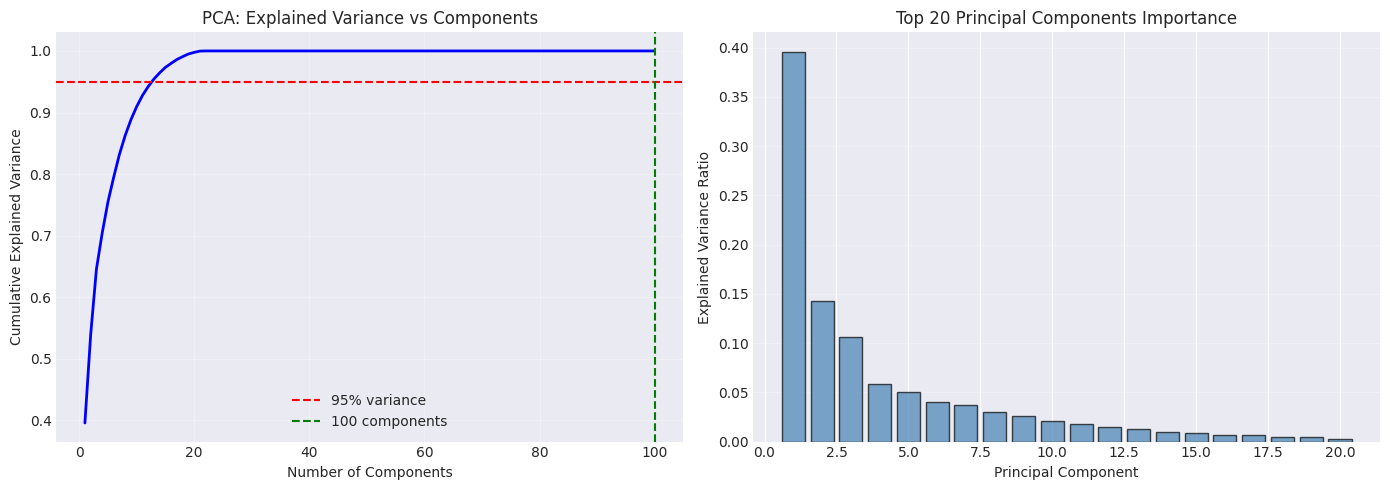


✓ First component explains 39.59% of variance
✓ Top 10 components explain 90.97% of variance
✓ Top 100 components explain 100.00% of variance
✓ PCA reduces dimensions while preserving most information


In [50]:
# Visualize PCA Effect
print("Visualizing PCA dimensionality reduction...\n")

# Get multi-features
X_processed_pca = preprocessing_advanced(X[:1000])
X_features_pca = feature_multi(X[:1000], X_processed_pca)

print(f"Original feature dimension: {X_features_pca.shape[1]}")

# Apply PCA with different components
n_components_list = [10, 50, 100, X_features_pca.shape[1]]
explained_variances = []

for n_comp in n_components_list:
    pca_temp = PCA(n_components=min(n_comp, X_features_pca.shape[1]))
    X_pca_temp = pca_temp.fit_transform(X_features_pca)
    explained_var = pca_temp.explained_variance_ratio_.sum()
    explained_variances.append(explained_var)
    print(f"  {n_comp:3d} components: {explained_var*100:.2f}% variance explained")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Explained variance ratio
pca_full = PCA()
pca_full.fit(X_features_pca)
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

axes[0].plot(range(1, min(101, len(cumsum_var)+1)), cumsum_var[:100], 'b-', linewidth=2)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[0].axvline(x=100, color='g', linestyle='--', label='100 components')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA: Explained Variance vs Components', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Component importance
axes[1].bar(range(1, 21), pca_full.explained_variance_ratio_[:20], 
           color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('Top 20 Principal Components Importance', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ First component explains {pca_full.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"✓ Top 10 components explain {cumsum_var[9]*100:.2f}% of variance")
print(f"✓ Top 100 components explain {cumsum_var[99]*100:.2f}% of variance")
print("✓ PCA reduces dimensions while preserving most information")


Visualizing how PCA transforms the feature space...



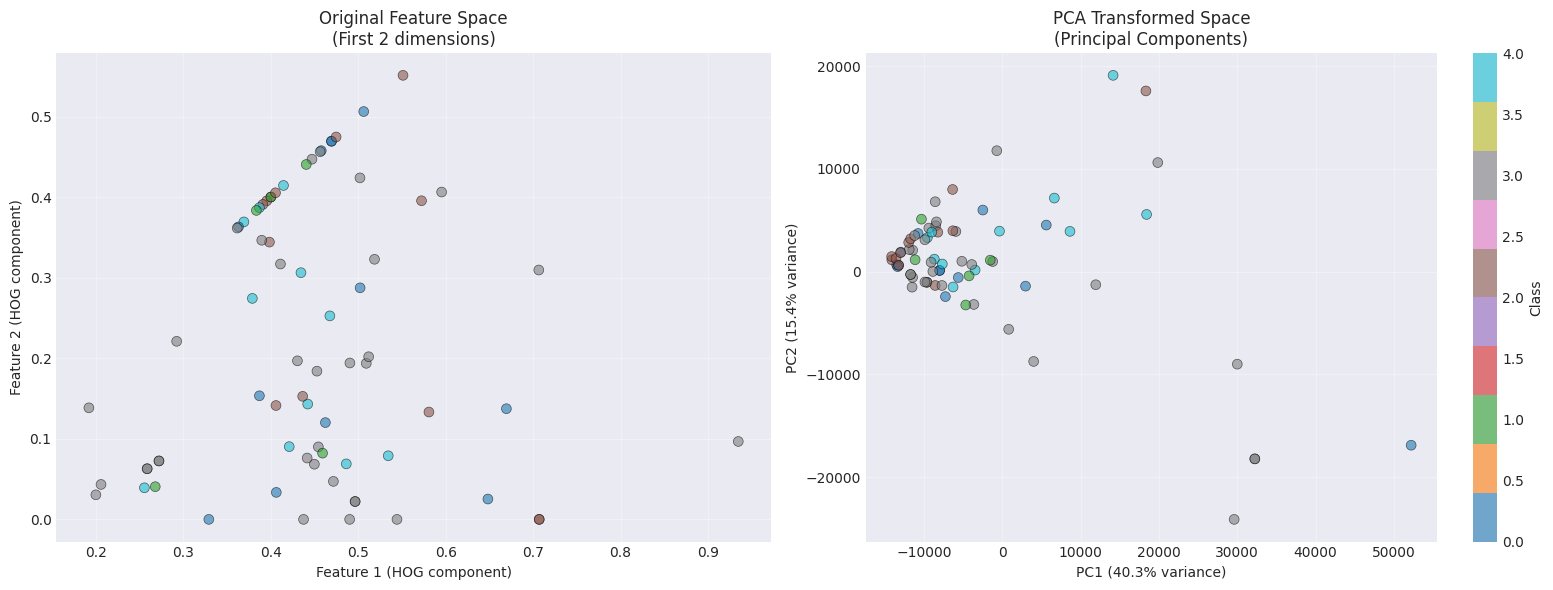

✓ PCA rotates data to align with directions of maximum variance
✓ Classes become more separated in PCA space
✓ This makes classification easier


In [51]:
# Visualize PCA Transformation Effect
print("Visualizing how PCA transforms the feature space...\n")

# Use subset for visualization
X_processed_pca2 = preprocessing_advanced(X[:500])
X_features_pca2 = feature_multi(X[:500], X_processed_pca2)
y_pca2 = y[:500]

# Apply PCA
pca_viz = PCA(n_components=2)
X_pca_2d = pca_viz.fit_transform(X_features_pca2)

# Get class labels for first 5 classes
unique_classes_viz = sorted(set(y_pca2))[:5]
class_colors = {cls: idx for idx, cls in enumerate(unique_classes_viz)}
y_colors = [class_colors.get(cls, -1) for cls in y_pca2]

# Filter
mask_viz = np.array([cls in unique_classes_viz for cls in y_pca2])
X_original_2d = X_features_pca2[mask_viz]
X_pca_2d_filtered = X_pca_2d[mask_viz]
y_colors_filtered = np.array(y_colors)[mask_viz]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original feature space (first 2 dimensions)
axes[0].scatter(X_original_2d[:, 0], X_original_2d[:, 1], 
               c=y_colors_filtered, cmap=plt.cm.tab10, 
               alpha=0.6, edgecolors='black', linewidths=0.5, s=50)
axes[0].set_xlabel('Feature 1 (HOG component)')
axes[0].set_ylabel('Feature 2 (HOG component)')
axes[0].set_title('Original Feature Space\n(First 2 dimensions)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# PCA transformed space
scatter = axes[1].scatter(X_pca_2d_filtered[:, 0], X_pca_2d_filtered[:, 1],
                         c=y_colors_filtered, cmap=plt.cm.tab10,
                         alpha=0.6, edgecolors='black', linewidths=0.5, s=50)
axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[1].set_title('PCA Transformed Space\n(Principal Components)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[1], label='Class')
plt.tight_layout()
plt.show()

print("✓ PCA rotates data to align with directions of maximum variance")
print("✓ Classes become more separated in PCA space")
print("✓ This makes classification easier")


## Exploration 1: Different Preprocessing Methods

**Goal**: Compare how different preprocessing techniques affect classification accuracy.

**Setup**: 
- Feature: HOG (standard feature extraction)
- Classifier: SVM (standard classifier)
- Variable: Preprocessing method

We'll test 4 preprocessing methods to see which improves accuracy most.


In [52]:
# Exploration 1: Compare Preprocessing Methods
print("=" * 60)
print("EXPLORATION 1: Different Preprocessing Methods")
print("=" * 60)
print("Testing: HOG features + SVM classifier\n")

# Test different preprocessing methods
preprocessing_methods = {
    'Simple': preprocessing_simple,
    'Blur': preprocessing_blur,
    'Histogram Eq': preprocessing_histogram_eq,
    'Advanced': preprocessing_advanced,
}

results_preprocessing = []
classifier = SVC()

for prep_name, prep_func in preprocessing_methods.items():
    # Preprocess
    X_processed = prep_func(X)
    
    # Extract features
    X_features = feature_HOG(X_processed)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.2, random_state=42
    )
    
    # Train and evaluate
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    
    results_preprocessing.append({
        'Preprocessing': prep_name,
        'Accuracy': accuracy
    })
    print(f"  {prep_name:20s}: {accuracy:.4f}")

df_preprocessing = pd.DataFrame(results_preprocessing)
print("\n" + df_preprocessing.to_string(index=False))

# Find best preprocessing
best_prep = df_preprocessing.loc[df_preprocessing['Accuracy'].idxmax()]
print(f"\n✓ Best preprocessing: {best_prep['Preprocessing']} ({best_prep['Accuracy']:.4f})")



EXPLORATION 1: Different Preprocessing Methods
Testing: HOG features + SVM classifier

  Simple              : 0.9417
  Blur                : 0.9558
  Histogram Eq        : 0.9475
  Advanced            : 0.9442

Preprocessing  Accuracy
       Simple  0.941667
         Blur  0.955833
 Histogram Eq  0.947500
     Advanced  0.944167

✓ Best preprocessing: Blur (0.9558)


## Exploration 2: Different Classifiers

**Goal**: Compare how different classifiers perform on the same features.

**Setup**:
- Preprocessing: Blur (from baseline)
- Features: HOG (standard feature extraction)
- Variable: Classifier type

We'll test 6 different classifiers to see which performs best.

### Classifier Mechanisms Explained:

1. **SVM (Support Vector Machine)**
   - Finds optimal hyperplanes that separate classes
   - Maximizes margin between classes
   - Uses kernel trick to handle non-linear boundaries
   - Good for high-dimensional features

2. **Random Forest**
   - Ensemble of decision trees
   - Each tree votes on the class
   - Reduces overfitting through averaging
   - Handles non-linear relationships well

3. **kNN (k-Nearest Neighbors)**
   - Classifies based on k nearest training samples
   - Simple, instance-based learning
   - No explicit training phase
   - Sensitive to feature scaling

4. **Decision Tree**
   - Makes decisions through a tree of if-else rules
   - Easy to interpret
   - Can overfit easily
   - Handles non-linear boundaries

5. **Naive Bayes**
   - Uses Bayes' theorem with independence assumption
   - Fast and simple
   - Works well with small datasets
   - Assumes features are independent

6. **MLP (Multi-Layer Perceptron)**
   - Neural network with multiple layers
   - Learns complex non-linear patterns
   - Requires more data and tuning
   - Can approximate any function


In [53]:
# Exploration 2: Compare Classifiers
print("=" * 60)
print("EXPLORATION 2: Different Classifiers")
print("=" * 60)
print("Testing: Blur preprocessing + HOG features\n")

# Preprocess (using blur from baseline)
X_processed = preprocessing_blur(X)
print(f"✓ Preprocessed: {len(X_processed)} images")

# Extract features
X_features = feature_HOG(X_processed)
print(f"✓ Features extracted: {X_features.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42
)

# Define classifiers
classifiers = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'kNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=500)
}

results_classifiers = []
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    results_classifiers.append({'Classifier': name, 'Accuracy': accuracy})
    print(f"  {name:20s}: {accuracy:.4f}")

df_classifiers = pd.DataFrame(results_classifiers)
print("\n" + df_classifiers.to_string(index=False))

# Find best classifier
best_classifier = df_classifiers.loc[df_classifiers['Accuracy'].idxmax()]
print(f"\n✓ Best classifier: {best_classifier['Classifier']} ({best_classifier['Accuracy']:.4f})")



EXPLORATION 2: Different Classifiers
Testing: Blur preprocessing + HOG features

✓ Preprocessed: 5998 images
✓ Features extracted: (5998, 128)
  SVM                 : 0.9558
  Random Forest       : 0.9717
  kNN                 : 0.8633
  Decision Tree       : 0.9300
  Naive Bayes         : 0.7992
  MLP                 : 0.9700

   Classifier  Accuracy
          SVM  0.955833
Random Forest  0.971667
          kNN  0.863333
Decision Tree  0.930000
  Naive Bayes  0.799167
          MLP  0.970000

✓ Best classifier: Random Forest (0.9717)


### 2. Random Forest

**How Random Forest Works:**

Random Forest is an ensemble method that combines multiple decision trees. Each tree votes on the class, and the majority vote wins.

![Random Forest](https://upload.wikimedia.org/wikipedia/commons/4/4e/Random_forest_explain.png)

*Image source: Wikipedia - Shows how multiple trees vote on the final prediction*

**Key Concepts:**
- **Bootstrap Sampling**: Each tree trained on random subset of data
- **Feature Randomness**: Each split considers random subset of features
- **Voting**: Final prediction is majority vote of all trees
- **Advantages**: Handles overfitting well, works with non-linear data, feature importance
- **Disadvantages**: Less interpretable than single tree, can be slow with many trees

### 3. kNN (k-Nearest Neighbors)

**How kNN Works:**

kNN classifies a sample based on the k nearest training examples. It's a lazy learning algorithm (no explicit training).

![kNN Mechanism](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg)

*Image source: Wikipedia - Shows how kNN finds k nearest neighbors*

**Key Concepts:**
- **Distance Metric**: Usually Euclidean distance
- **k Value**: Number of neighbors to consider (small k = sensitive, large k = smooth)
- **Voting**: Class is determined by majority of k neighbors
- **Advantages**: Simple, no training phase, works well for non-linear boundaries
- **Disadvantages**: Slow prediction, sensitive to irrelevant features, needs feature scaling

### 4. Decision Tree

**How Decision Tree Works:**

Decision Tree makes decisions through a series of if-else rules, splitting data based on feature values.

![Decision Tree](https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png)

*Image source: Wikipedia - Shows decision tree structure with splits*

**Key Concepts:**
- **Splits**: Choose features that best separate classes (e.g., entropy, Gini)
- **Nodes**: Decision points (internal) or predictions (leaves)
- **Pruning**: Removes branches to prevent overfitting
- **Advantages**: Easy to interpret, handles non-linear data, no feature scaling needed
- **Disadvantages**: Prone to overfitting, unstable (small data changes → different tree)

### 5. Naive Bayes

**How Naive Bayes Works:**

Naive Bayes uses Bayes' theorem with the "naive" assumption that features are independent.

![Naive Bayes](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*J5MLEJwQqhW41wg6.png)

*Image source: Wikipedia - Shows Naive Bayes classification process*

**Key Concepts:**
- **Bayes' Theorem**: P(class|features) = P(features|class) × P(class) / P(features)
- **Independence Assumption**: Features are independent (often not true, but works anyway)
- **Prior Probability**: P(class) - how common each class is
- **Likelihood**: P(features|class) - probability of features given class
- **Advantages**: Fast, works well with small datasets, handles multiple classes
- **Disadvantages**: Independence assumption rarely true, can be outperformed by other methods

### 6. MLP (Multi-Layer Perceptron)

**How MLP Works:**

MLP is a feedforward neural network with multiple layers of neurons.

![MLP Architecture](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

*Image source: Wikipedia - Shows neural network architecture with input, hidden, and output layers*

**Key Concepts:**
- **Input Layer**: Receives feature vectors
- **Hidden Layers**: Learn non-linear transformations
- **Output Layer**: Produces class predictions
- **Activation Functions**: Introduce non-linearity (ReLU, sigmoid, tanh)
- **Backpropagation**: Updates weights to minimize error
- **Gradient Descent**: Optimizes the network
- **Advantages**: Can learn complex patterns, universal function approximator
- **Disadvantages**: Requires more data, needs tuning (learning rate, layers, etc.), can overfit


Visualizing how different classifiers separate classes...



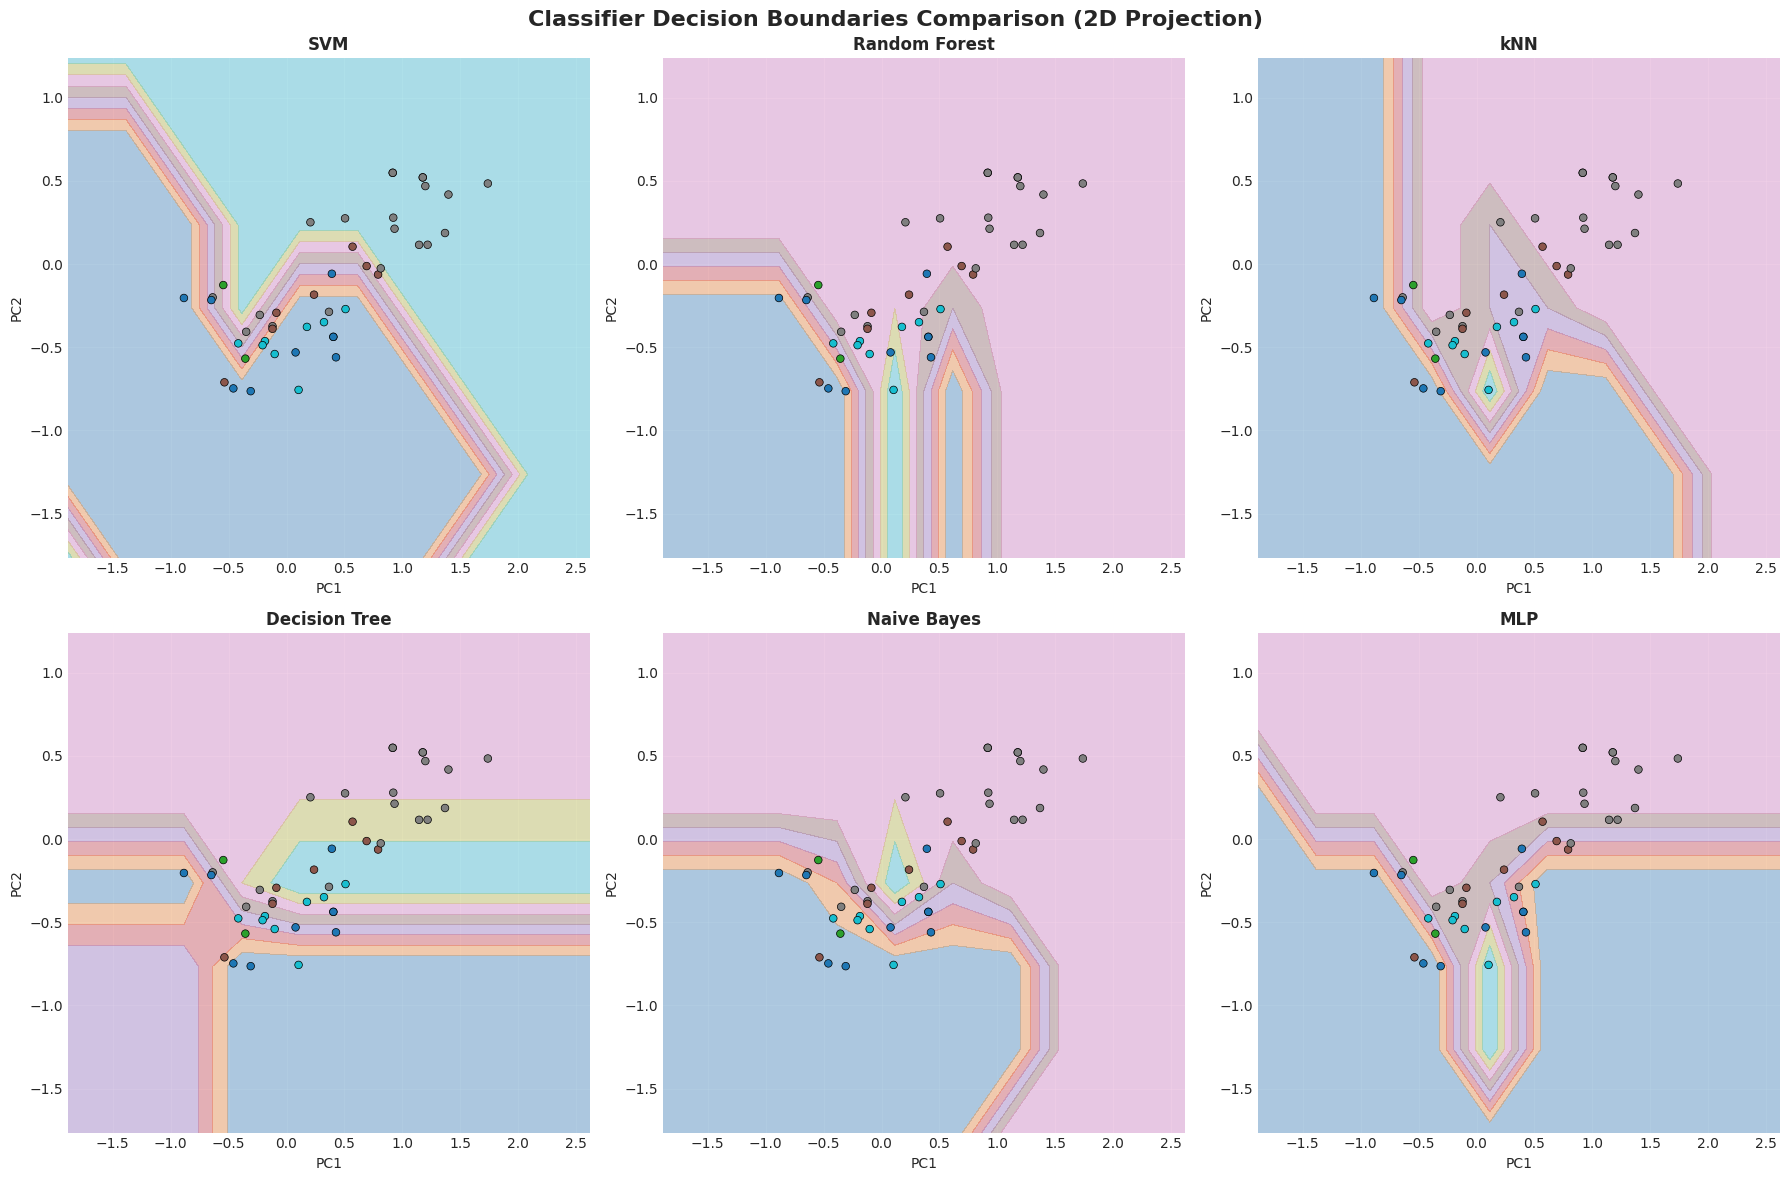

✓ Different classifiers create different decision boundaries
✓ SVM: Smooth boundaries with maximum margin
✓ Random Forest: Complex, piecewise boundaries
✓ kNN: Voronoi-like regions
✓ Decision Tree: Axis-aligned rectangular regions
✓ Naive Bayes: Elliptical regions (Gaussian assumption)
✓ MLP: Smooth, complex non-linear boundaries


In [54]:
# Visualize Classifier Decision Boundaries (2D projection)
print("Visualizing how different classifiers separate classes...\n")

# Use subset for speed
X_processed_clf = preprocessing_blur(X[:300])
X_features_clf = feature_HOG(X_processed_clf)
y_clf = y[:300]

# Reduce to 2D using PCA
pca_clf = PCA(n_components=2)
X_2d_clf = pca_clf.fit_transform(X_features_clf)

# Use first 5 classes for visualization
unique_classes_clf = sorted(set(y_clf))[:5]
class_to_num_clf = {cls: idx for idx, cls in enumerate(unique_classes_clf)}
y_numeric_clf = np.array([class_to_num_clf.get(cls, -1) for cls in y_clf])

mask_clf = np.array([cls in unique_classes_clf for cls in y_clf])
X_2d_clf_filtered = X_2d_clf[mask_clf]
y_numeric_clf_filtered = y_numeric_clf[mask_clf]

# Train classifiers
classifiers_viz = {
    'SVM': SVC(kernel='rbf', C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=5),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Classifier Decision Boundaries Comparison (2D Projection)', fontsize=16, fontweight='bold')

for idx, (name, clf) in enumerate(classifiers_viz.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Train classifier
    clf.fit(X_2d_clf_filtered, y_numeric_clf_filtered)
    
    # Create mesh
    h = 0.5
    x_min, x_max = X_2d_clf_filtered[:, 0].min() - 1, X_2d_clf_filtered[:, 0].max() + 1
    y_min, y_max = X_2d_clf_filtered[:, 1].min() - 1, X_2d_clf_filtered[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    scatter = ax.scatter(X_2d_clf_filtered[:, 0], X_2d_clf_filtered[:, 1],
                        c=y_numeric_clf_filtered, cmap=plt.cm.tab10,
                        edgecolors='black', linewidths=0.5, s=30)
    
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Different classifiers create different decision boundaries")
print("✓ SVM: Smooth boundaries with maximum margin")
print("✓ Random Forest: Complex, piecewise boundaries")
print("✓ kNN: Voronoi-like regions")
print("✓ Decision Tree: Axis-aligned rectangular regions")
print("✓ Naive Bayes: Elliptical regions (Gaussian assumption)")
print("✓ MLP: Smooth, complex non-linear boundaries")


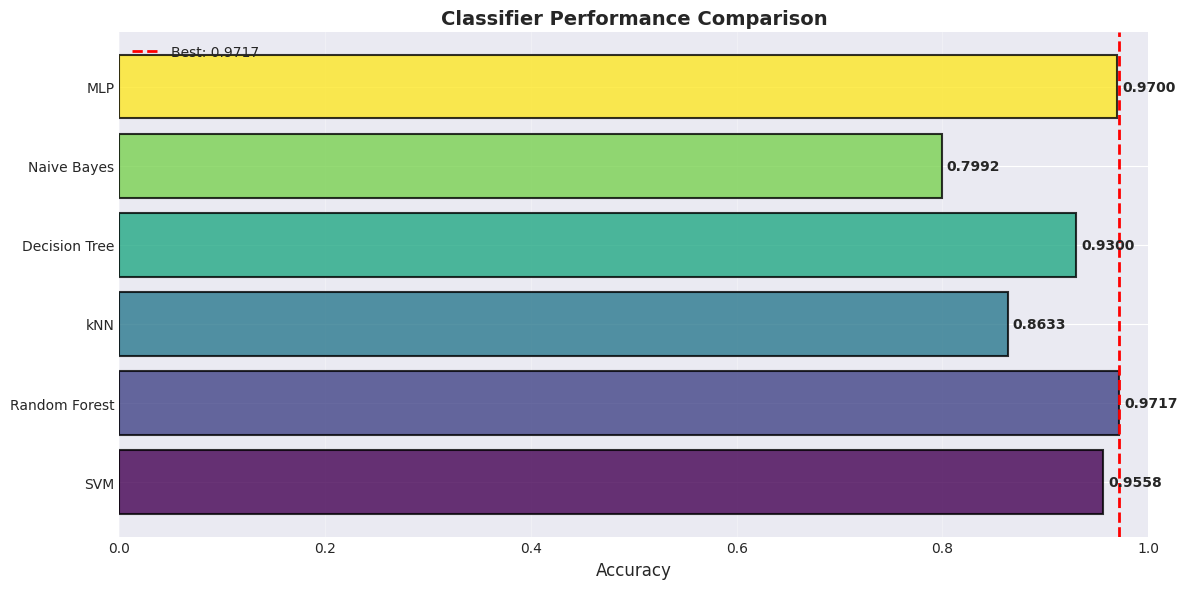

✓ Bar chart shows relative performance of each classifier
✓ Best classifier: Random Forest


In [ ]:
# Visualize Classifier Performance Comparison
# Run this after Exploration 2 to see visual comparison

if 'df_classifiers' in globals() and len(df_classifiers) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(df_classifiers)))
    bars = ax.barh(df_classifiers['Classifier'], df_classifiers['Accuracy'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df_classifiers.iterrows()):
        ax.text(row['Accuracy'] + 0.005, i, f"{row['Accuracy']:.4f}", 
               va='center', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Accuracy', fontsize=12)
    ax.set_title('Classifier Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1.0])
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=df_classifiers['Accuracy'].max(), color='red', 
              linestyle='--', linewidth=2, label=f"Best: {df_classifiers['Accuracy'].max():.4f}")
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Bar chart shows relative performance of each classifier")
    print(f"✓ Best classifier in this test: {df_classifiers.loc[df_classifiers['Accuracy'].idxmax(), 'Classifier']}")
else:
    print("⚠ Run Exploration 2 first to generate classifier comparison data.")


## Exploration 3: Advanced Techniques & Combinations

**Goal**: Explore advanced techniques and find best combinations.

### Part A: Multi-feature + PCA + Scaling

**PCA (Principal Component Analysis)?**
- **Purpose**: Reduces dimensionality while preserving most information
- **How it works**: 
  1. Finds directions (principal components) with most variance
  2. Projects data onto these components
  3. Keeps only top N components (e.g., 100 out of 155)
- **Benefits**: 
  - Reduces overfitting
  - Speeds up training
  - Removes noise
- **Trade-off**: Some information loss, but usually minimal

**Why Feature Scaling?**
- Different features have different scales (e.g., HOG: 0-1, area: 0-2304)
- Many classifiers (SVM, kNN, MLP) are sensitive to scale
- Scaling ensures all features contribute equally
- StandardScaler: transforms to mean=0, std=1

**Configuration**: Advanced preprocessing + Multi-feature (HOG+Color+Shape) + PCA + Scaling


In [56]:
# Exploration 3A: Multi-feature + PCA + Scaling
print("=" * 60)
print("EXPLORATION 3A: Multi-feature + PCA + Scaling")
print("=" * 60)

# Preprocess
X_processed = preprocessing_advanced(X)
print(f"✓ Preprocessed: {len(X_processed)} images")

# Extract multi-features
X_features = feature_multi(X, X_processed)
print(f"✓ Features extracted: {X_features.shape} (before PCA)")

# Apply PCA
pca = PCA(n_components=100)
X_features = pca.fit_transform(X_features)
print(f"✓ After PCA: {X_features.shape} (reduced from {feature_multi(X[:1], X_processed[:1]).shape[1]} to 100)")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42
)

# Test classifiers with scaling
results_advanced = []
for name, classifier in classifiers.items():
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    classifier.fit(X_train_scaled, y_train)
    accuracy = classifier.score(X_test_scaled, y_test)
    results_advanced.append({'Classifier': name, 'Accuracy': accuracy})
    print(f"  {name:20s}: {accuracy:.4f}")

df_advanced = pd.DataFrame(results_advanced)
print("\n" + df_advanced.to_string(index=False))



EXPLORATION 3A: Multi-feature + PCA + Scaling
✓ Preprocessed: 5998 images
✓ Features extracted: (5998, 155) (before PCA)
✓ After PCA: (5998, 100) (reduced from 155 to 100)
  SVM                 : 0.9600
  Random Forest       : 0.9483
  kNN                 : 0.7950
  Decision Tree       : 0.8967
  Naive Bayes         : 0.7575
  MLP                 : 0.9650

   Classifier  Accuracy
          SVM  0.960000
Random Forest  0.948333
          kNN  0.795000
Decision Tree  0.896667
  Naive Bayes  0.757500
          MLP  0.965000


### Part B: All Combinations Comparison

**Goal**: Systematically test all combinations of preprocessing × feature extraction × classifier to find the optimal setup.

This is computationally expensive but gives comprehensive results.


In [57]:
# Exploration 3B: All Combinations
print("=" * 60)
print("EXPLORATION 3B: All Combinations Comparison")
print("=" * 60)
print("Testing: preprocessing × feature extraction × classifier\n")

# Define methods (subset for speed - can expand)
preprocessing_methods = {
    'Simple': preprocessing_simple,
    'Blur': preprocessing_blur,
    'Histogram Eq': preprocessing_histogram_eq,
}

feature_methods = {
    'HOG': feature_HOG,
    'LBP': feature_LBP,
    'Pyramid': feature_pyramid,
    'FFT': feature_FFT,
    'Hu Moments': feature_HuMoments,
}

# Test combinations (using SVM for speed - can test all classifiers)
results_combinations = []
classifier = SVC()

for prep_name, prep_func in preprocessing_methods.items():
    X_processed = prep_func(X)
    
    for feat_name, feat_func in feature_methods.items():
        try:
            X_features = feat_func(X_processed)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_features, y, test_size=0.2, random_state=42
            )
            
            classifier.fit(X_train, y_train)
            accuracy = classifier.score(X_test, y_test)
            
            results_combinations.append({
                'Preprocessing': prep_name,
                'Feature': feat_name,
                'Accuracy': accuracy
            })
            print(f"  {prep_name:15s} × {feat_name:15s}: {accuracy:.4f}")
        except Exception as e:
            print(f"  {prep_name:15s} × {feat_name:15s}: ERROR - {str(e)[:30]}")

df_combinations = pd.DataFrame(results_combinations)
if len(df_combinations) > 0:
    print("\n" + df_combinations.to_string(index=False))
    
    # Find best combination
    best = df_combinations.loc[df_combinations['Accuracy'].idxmax()]
    print(f"\n✓ Best combination: {best['Preprocessing']} × {best['Feature']} = {best['Accuracy']:.4f}")


EXPLORATION 3B: All Combinations Comparison
Testing: preprocessing × feature extraction × classifier

  Simple          × HOG            : 0.9417
  Simple          × LBP            : 0.9158
  Simple          × Pyramid        : 0.8175
  Simple          × FFT            : 0.7950
  Simple          × Hu Moments     : 0.0858
  Blur            × HOG            : 0.9558
  Blur            × LBP            : 0.9275
  Blur            × Pyramid        : 0.7533
  Blur            × FFT            : 0.5825
  Blur            × Hu Moments     : 0.0875
  Histogram Eq    × HOG            : 0.9475
  Histogram Eq    × LBP            : 0.9075
  Histogram Eq    × Pyramid        : 0.8775
  Histogram Eq    × FFT            : 0.8283
  Histogram Eq    × Hu Moments     : 0.0850

Preprocessing    Feature  Accuracy
       Simple        HOG  0.941667
       Simple        LBP  0.915833
       Simple    Pyramid  0.817500
       Simple        FFT  0.795000
       Simple Hu Moments  0.085833
         Blur        HOG  0

In [58]:
# Summary
print("=" * 60)
print("SUMMARY & CONCLUSIONS")
print("=" * 60)

print("\n1. Preprocessing Methods Comparison:")
print(df_preprocessing.to_string(index=False))

print("\n2. Classifiers Comparison:")
print(df_classifiers.to_string(index=False))

print("\n3. Advanced Approach (Multi-feature + PCA + Scaling):")
print(df_advanced.to_string(index=False))

if len(results_combinations) > 0:
    print("\n4. Best Combinations (Preprocessing × Feature):")
    print(df_combinations.nlargest(5, 'Accuracy').to_string(index=False))

# Compare best accuracies
best_prep = df_preprocessing['Accuracy'].max()
best_classifier = df_classifiers['Accuracy'].max()
best_advanced = df_advanced['Accuracy'].max()
best_combination = df_combinations['Accuracy'].max() if len(results_combinations) > 0 else 0

print("\n" + "=" * 60)
print("BEST RESULTS:")
print("=" * 60)
print(f"Best Preprocessing:        {df_preprocessing.loc[df_preprocessing['Accuracy'].idxmax(), 'Preprocessing']:20s} ({best_prep:.4f})")
print(f"Best Classifier:           {df_classifiers.loc[df_classifiers['Accuracy'].idxmax(), 'Classifier']:20s} ({best_classifier:.4f})")
print(f"Advanced Approach:         Multi-feature+PCA+Scaling ({best_advanced:.4f})")
if best_combination > 0:
    best_combo = df_combinations.loc[df_combinations['Accuracy'].idxmax()]
    print(f"Best Combination:         {best_combo['Preprocessing']} × {best_combo['Feature']:20s} ({best_combination:.4f})")

print("\n" + "=" * 60)
print("KEY INSIGHTS:")
print("=" * 60)
if best_advanced > best_classifier:
    improvement = (best_advanced - best_classifier) * 100
    print(f"✓ Multi-feature + PCA improves by {improvement:.2f}% over single features")
else:
    print("✓ Single features perform well")

if best_combination > 0 and best_combination > best_advanced:
    print(f"✓ Best combination outperforms advanced approach")
    print(f"  → Use: {df_combinations.loc[df_combinations['Accuracy'].idxmax(), 'Preprocessing']} + {df_combinations.loc[df_combinations['Accuracy'].idxmax(), 'Feature']}")
else:
    print("✓ Advanced approach (multi-feature + PCA) is optimal")



SUMMARY & CONCLUSIONS

1. Preprocessing Methods Comparison:
Preprocessing  Accuracy
       Simple  0.941667
         Blur  0.955833
 Histogram Eq  0.947500
     Advanced  0.944167

2. Classifiers Comparison:
   Classifier  Accuracy
          SVM  0.955833
Random Forest  0.971667
          kNN  0.863333
Decision Tree  0.930000
  Naive Bayes  0.799167
          MLP  0.970000

3. Advanced Approach (Multi-feature + PCA + Scaling):
   Classifier  Accuracy
          SVM  0.960000
Random Forest  0.948333
          kNN  0.795000
Decision Tree  0.896667
  Naive Bayes  0.757500
          MLP  0.965000

4. Best Combinations (Preprocessing × Feature):
Preprocessing Feature  Accuracy
         Blur     HOG  0.955833
 Histogram Eq     HOG  0.947500
       Simple     HOG  0.941667
         Blur     LBP  0.927500
       Simple     LBP  0.915833

BEST RESULTS:
Best Preprocessing:        Blur                 (0.9558)
Best Classifier:           Random Forest        (0.9717)
Advanced Approach:         Mult